In [36]:
#importing libraries
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import time
# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#dl libraraies
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization,Reshape,Dot,Concatenate,Add,Lambda
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import cv2
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
import os
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
# specifically for deeplearning.
from tensorflow.keras.layers import Dropout, Flatten,Activation,Input,Embedding
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import random as rn
from IPython.display import SVG
#import TSNE for visualisation of embeddings
from sklearn.manifold import TSNE 
# specifically for manipulating zipped images and getting numpy arrays of pixel values of images. 
from tqdm import tqdm
import os           
from random import shuffle  

In [6]:
# reading users file:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('u.user', sep='|', names=u_cols,encoding='latin-1')

# reading ratings file:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('u.data', sep='\t', names=r_cols,encoding='latin-1')

# reading items file:
i_cols = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
items = pd.read_csv('u.item', sep='|', names=i_cols,
encoding='latin-1')

# After loading the dataset, we should look at the content of each file (users, ratings, items).

# Looking at the user file
print("\nUser Data :")
print("shape : ", users.shape)
#print(users.head())

# We have 943 users in the dataset and each user has 5 features, i.e. user_ID, age, sex, occupation and zip_code. Now let’s look at the ratings file.

# Ratings Data
print("\nRatings Data :")
print("shape : ", ratings.shape)
#print(ratings.head())

# We have 100k ratings for different user and movie combinations. Now finally examine the items file.

# Item Data
print("\nItem Data :")
print("shape : ", items.shape)
#print(items.head())


User Data :
shape :  (943, 5)

Ratings Data :
shape :  (100000, 4)

Item Data :
shape :  (1682, 24)


In [7]:
items.head()


,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [ ]:
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
ratings.dtypes

user_id           int64
movie_id          int64
rating            int64
unix_timestamp    int64
dtype: object

In [ ]:
#converting the unix timestamp of ratings to a  date
from datetime import datetime
def time_stamp(k):
  return datetime.fromtimestamp(k).strftime('%d-%m-%Y')
ratings['rating_date'] = ratings['unix_timestamp'].apply(time_stamp)
ratings.head()

In [ ]:
#finding the no of days since the rating is given on movies from a specified date('01-11-1998')
date_format = "%d-%m-%Y"
def sub_dates(a):
  return (datetime.strptime('01-11-1998', date_format)-a).days   
def dat_strp(a):
    return datetime.strptime(a, date_format)
ratings['new_date']=ratings['rating_date'].apply(dat_strp)    
ratings['days_diff']=ratings['new_date'].apply(sub_dates) 
#conversion of no of days to years
ratings['years_diff']=round(ratings['days_diff']/365,2)
ratings.head() 

In [10]:
#dropping the below columns
ratings.drop(['unix_timestamp','new_date'],axis=1,inplace=True)
ratings.head()

,user_id,movie_id,rating,rating_date,days_diff,years_diff
0,196,242,3,04-12-1997,332,0.91
1,186,302,3,04-04-1998,211,0.58
2,22,377,1,07-11-1997,359,0.98
3,244,51,2,27-11-1997,339,0.93
4,166,346,1,02-02-1998,272,0.75


In [ ]:
ratings['years_diff'].describe()

count    100000.000000
mean          0.837096
std           0.169676
min           0.530000
25%           0.690000
50%           0.860000
75%           0.970000
max           1.120000
Name: years_diff, dtype: float64

In [ ]:
#for these values select m=0.425 and n=0.25
m,n=0.425,0.25
ratings['weighted_diff']=m*ratings['years_diff']+n
ratings.head()

In [12]:
#Now I am gonna create new ratings which are time based/temporal
ratings['final_ratings']=round(ratings['rating']/ratings['weighted_diff'],2)
ratings.head()

,user_id,movie_id,rating,rating_date,days_diff,years_diff,weighted_diff,final_ratings
0,196,242,3,04-12-1997,332,0.91,0.63675,4.71
1,186,302,3,04-04-1998,211,0.58,0.49650,6.04
2,22,377,1,07-11-1997,359,0.98,0.66650,1.50
3,244,51,2,27-11-1997,339,0.93,0.64525,3.10
4,166,346,1,02-02-1998,272,0.75,0.56875,1.76


In [13]:
n_users = ratings.user_id.unique().shape[0]
n_items = ratings.movie_id.unique().shape[0]
data_matrix = np.zeros((n_users, n_items))
#basically here I am filling the respective user ids(line[1]) and movies(line[2]) with the value final ratings(line[8])
for line in ratings.itertuples():
    data_matrix[line[1]-1,line[2]-1] = line[8]
data_matrix 

array([[6.93, 4.31, 5.96, ..., 0.  , 0.  , 0.  ],
       [7.42, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [6.93, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 9.35, 0.  , ..., 0.  , 0.  , 0.  ]])

In [ ]:
#created a copy of ratings as df 
df=ratings.copy()
df.head()

In [ ]:

df.isnull().sum()

In [ ]:
#train test split
train, test = train_test_split(df, test_size=0.1)
train.head()

In [17]:
rows = train.shape[0]
latent_size = 10
num_users = df['user_id'].nunique()
num_movies = df['movie_id'].nunique()

In [18]:
#A function to create embeddings for users and movies
def EmbeddingRec(EMBEDDING_SIZE, NUM_MOVIES, NUM_USERS, ROW_COUNT):
    movie_input = keras.Input(shape=(1,), name='movie_id')
     #movie embedding 
    movie_emb = Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_MOVIES+1, input_length=ROW_COUNT, name='movie_emb')(movie_input)
    movie_vec = Flatten(name='FlattenMovie')(movie_emb)
     #movie embedding model 
    movie_model = keras.Model(inputs=movie_input, outputs=movie_vec)
    
    user_input = keras.Input(shape=(1,), name='user_id')
    #user embedding
    user_emb = Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_USERS+1, input_length=ROW_COUNT, name='user_emb')(user_input)
    user_vec = Flatten(name='FlattenUser')(user_emb)
    #user embedding model
    user_model = Model(inputs=user_input, outputs=user_vec)
    #taking dot products of those embeddings
    merged = Dot(name = 'dot_product', normalize = True, axes = 2)([movie_emb, user_emb])
    #Dropout Regularization
    merged_dropout = Dropout(0.2)(merged)
    dense_1 = Dense(90,name='FullyConnected-1')(merged)
    dropout_1 = Dropout(0.2,name='Dropout_1')(dense_1)

    dense_2 = Dense(40,name='FullyConnected-2')(dropout_1)
    dropout_2 =Dropout(0.2,name='Dropout_2')(dense_2)

    dense_3 = Dense(20,name='FullyConnected-3')(dropout_2)
    dropout_3 = Dropout(0.2,name='Dropout_3')(dense_3)
    dense_4 = Dense(10,name='FullyConnected-4', activation='relu')(dropout_3)

    result = Dense(1, name='result', activation="relu") (dense_4)
    #Usings Adam's optimization
    adam = Adam(lr=0.001)
    #A final ratings prediction model which outputs the ratings
    model = Model([movie_input, user_input], result)
    model.compile(optimizer=adam,loss= 'mse')
    return model, movie_model, user_model

In [19]:
#creation of model
model, movie_model, user_model = EmbeddingRec(latent_size,num_movies,num_users,rows)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie_id (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_emb (Embedding)           (None, 1, 10)        16830       movie_id[0][0]                   
__________________________________________________________________________________________________
user_emb (Embedding)            (None, 1, 10)        9440        user_id[0][0]                    
____________________________________________________________________________________________

In [ ]:
movie_model.summary()

In [ ]:
#callbacks for early stopping on the basis of patience, i.e- not observing a significant improvement
callbacks = [keras.callbacks.EarlyStopping('val_loss', patience=10),
             keras.callbacks.ModelCheckpoint('besttest.h5', save_best_only=True)]
#training of model in training data along with a vaidation set to evaluate
history = model.fit([train.movie_id, train.user_id],train.final_ratings, batch_size=100,
                              epochs =50, validation_data = ([test.movie_id, test.user_id],test.final_ratings),
                              verbose = 1, 
                              callbacks = callbacks)

In [22]:
# checkout a sample user embedding for userid 10
user_model.predict(np.array([10]))

array([[-0.03839522, -0.04001302, -0.04725925,  0.1326495 , -0.07773536,
        -0.21287352,  0.08383255, -0.21331741,  0.0405644 , -0.17694035]],
      dtype=float32)

In [23]:
# checkout a sample movie embedding for movieid 10
movie_model.predict(np.array([10]))

array([[-0.33707038, -0.00237215, -0.07192912, -0.14777665,  0.07487016,
         0.01400185,  0.05103808, -0.13962418, -0.00801382,  0.0752388 ]],
      dtype=float32)

In [24]:
# checkout a sample user movie ranking for movie id 3 from user id 10
model.predict([np.array([10]), np.array([3])])

array([[[6.1295485]]], dtype=float32)

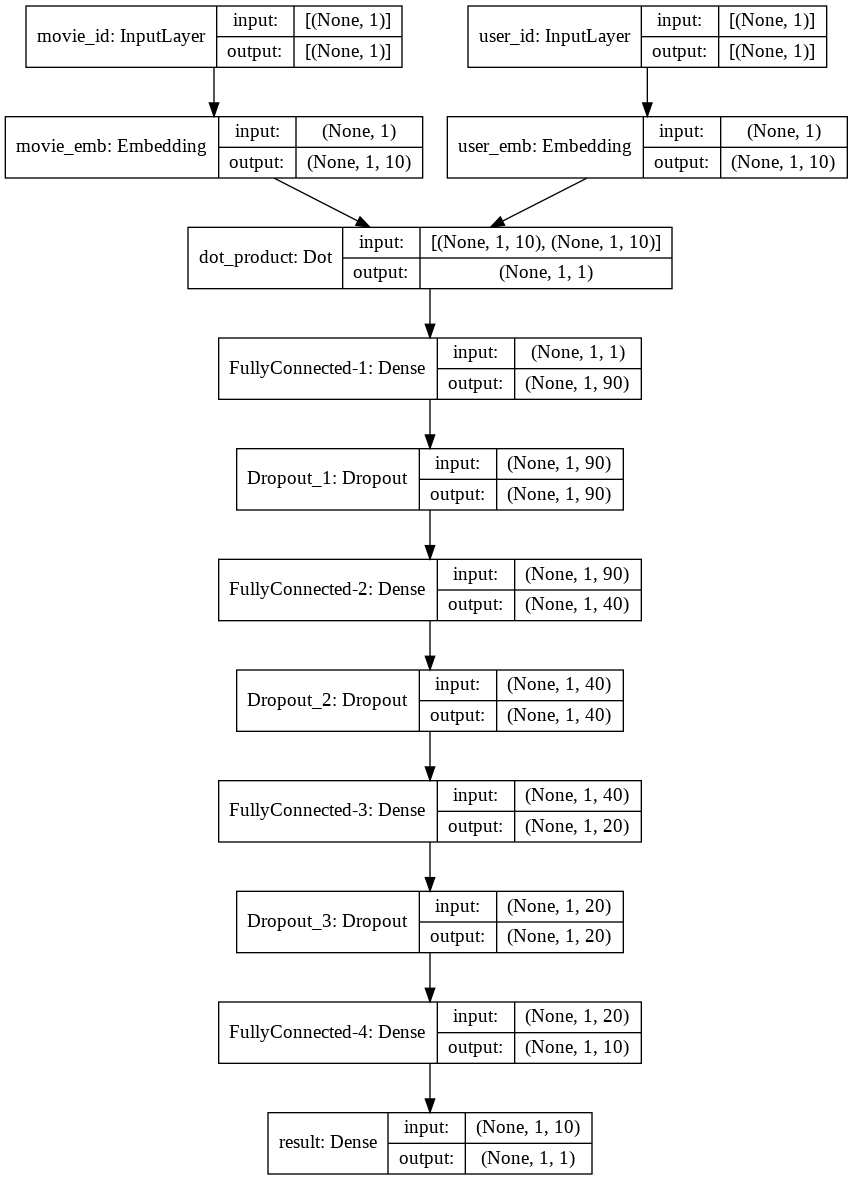

In [25]:
#Visualize the model architecture
keras.utils.plot_model(model, show_shapes=True)

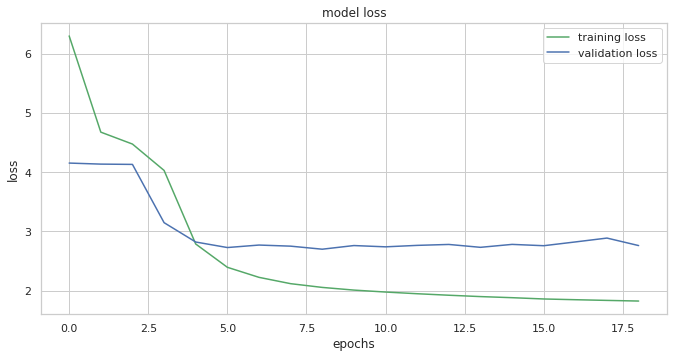

In [30]:
#Plotting the Loss Curve
from pylab import rcParams
import collections
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(history.history['loss'] , 'g', label="training loss")
plt.plot(history.history['val_loss'] , 'b', label="validation loss")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
#Extract Movie embedding
movie_embed_list = []
movie_embed_map = collections.defaultdict()
unique_movie_id = df['movie_id'].unique()
for _id in unique_movie_id:
    # emb contains the movie embeddings which were predicted by the movie model
    emb = movie_model.predict(np.array([_id]))
    val = list(emb.reshape(1,-1))[0]
    movie_embed_list.insert(_id, val)
    movie_embed_map[_id] = val

In [55]:
#embeddings for movie_id 1
movie_embed_list[0]

array([-0.2247791 ,  0.1783879 , -0.05228725,  0.00435158,  0.07232182,
       -0.04456355,  0.05162591, -0.19554389, -0.10987931,  0.06910676],
      dtype=float32)

In [37]:
#Visualise Embeddings
def tsne_plot(model,movie_embed_list,size = num_movies):
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(movie_embed_list[:size])
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    labels = list(range(0,size))
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],xy=(x[i], y[i]),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom')
    plt.show()

In [ ]:
tsne_plot(model, movie_embed_list)


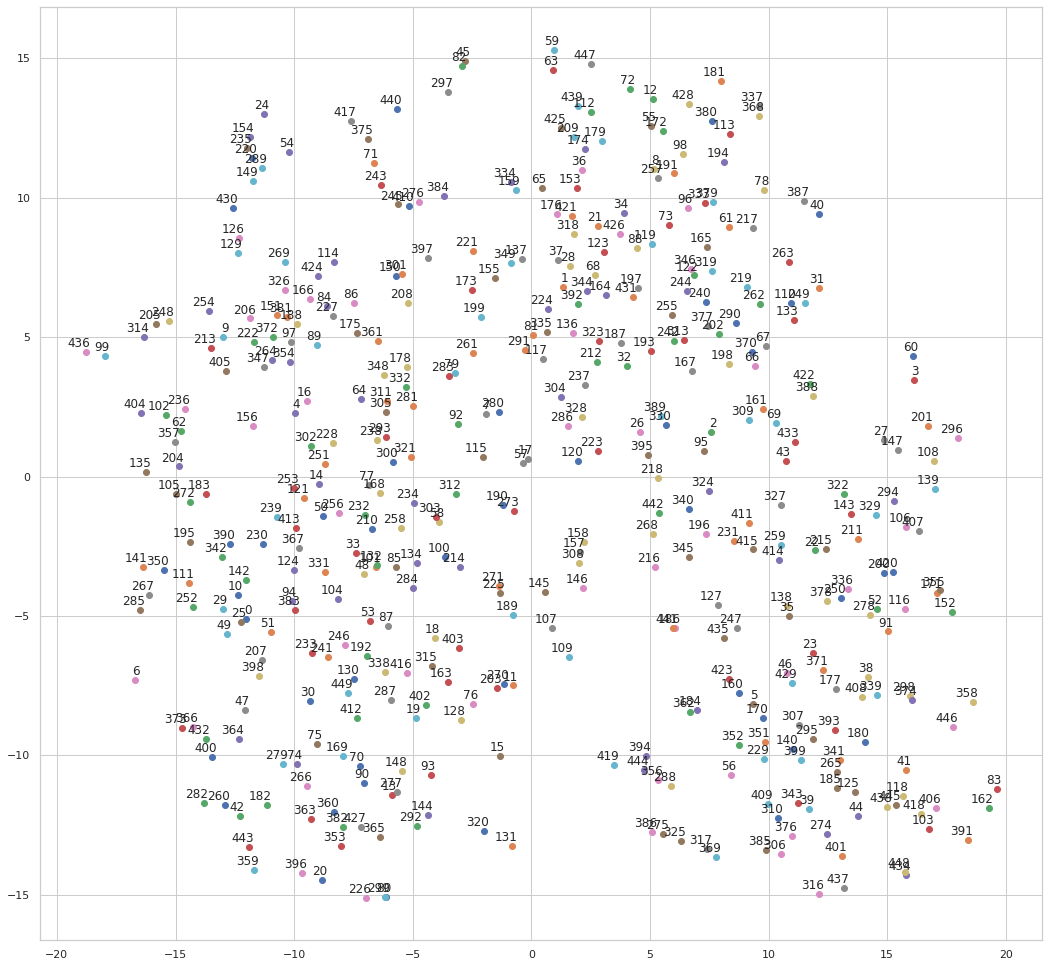

In [39]:
#to visualise only upto user id 450 because of large time taken
tsne_plot(model,movie_embed_list, 450)


In [56]:
#Top-K Candidates using K-Nearest Neighbor
from sklearn.neighbors import KNeighborsClassifier
knn_train_label = unique_movie_id
clf = KNeighborsClassifier(n_neighbors=11)
#model has been trained such that whenever its given any embedding it will predict the movie id
clf.fit(movie_embed_list, knn_train_label)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='uniform')

In [57]:
#merging ratings dataset with items to get titles of movies
items_new=items[['movie id', 'movie title']]
items_new.rename(columns={"movie id": "movie_id"},inplace=True)
new_df=pd.merge(df,items_new,on=['movie_id'],how='inner')
new_df.head()

,user_id,movie_id,rating,rating_date,days_diff,years_diff,weighted_diff,final_ratings,movie title
0,196,242,3,04-12-1997,332,0.91,0.63675,4.71,Kolya (1996)
1,63,242,3,01-10-1997,396,1.08,0.70900,4.23,Kolya (1996)
2,226,242,5,04-01-1998,301,0.82,0.59850,8.35,Kolya (1996)
3,154,242,3,10-11-1997,356,0.98,0.66650,4.50,Kolya (1996)
4,306,242,5,10-10-1997,387,1.06,0.70050,7.14,Kolya (1996)


In [58]:
#Creating a KNN Model which utilises embeddings as a parameter for prediction of similar movies  
def recommend_movies(embedding):
    distances, indices = clf.kneighbors(embedding.reshape(1, -1),  n_neighbors=10)
    distances,indices = distances.reshape(10,1),indices.reshape(10,1)
    #print(indices)
    df_indices = pd.DataFrame(indices, columns = ['movie_id'])
    #df_distances = pd.DataFrame(distances, columns = ['movie_id'])
    return df_indices.merge(new_df,on='movie_id',how='inner',suffixes=['_u', '_m'])['movie title'].unique()

In [48]:
#suppose we check predictions for user id 40
test_user=40

In [60]:
#if user embeddings ar similar to a movie id embedding, the user can be recommended that movie
user_embedding = user_model.predict([test_user]).reshape(1,-1)[0]
recommend_movies(user_embedding)


array(['Vermont Is For Lovers (1992)', 'Ed (1996)',
       'Object of My Affection, The (1998)', 'Band Wagon, The (1953)',
       'Jurassic Park (1993)', 'Shooter, The (1995)',
       'Unforgettable (1996)', 'Fools Rush In (1997)',
       'Marked for Death (1990)', 'Three Colors: Blue (1993)'],
      dtype=object)